In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
#from xgboost.sklearn import XGBClassifier
from xgboost import XGBClassifier
# from sklearn import cross_validation, metrics
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics

from xgboost import plot_importance
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8

from numpy import sort
from sklearn.feature_selection import SelectFromModel

# # Ignore warnings
# import warnings
# warnings.simplefilter('ignore')

In [2]:
# Import the train set and test set
train_data2 = pd.read_csv("trainset.csv", delimiter=",")
test_data2 = pd.read_csv("testset.csv", delimiter=",")

train = pd.read_csv("normalized_train_dataset.csv", delimiter=",").fillna(0)
test = pd.read_csv("normalized_test_dataset.csv", delimiter=",").fillna(0)

#train = train.dropna()
# test = test.dropna()

In [3]:
train.shape, test.shape

((9567, 35), (3190, 34))

In [4]:
target = 'Product'
IDcol = 'ID'

In [5]:
#test_results = pd.read_csv('test_results.csv')
def modelfit2(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    # fit model on training data
    model = alg
    
    X_train, X_test, y_train, y_test = train_test_split(dtrain[predictors], dtrain[target], test_size=0.33, random_state=7)
    eval_set = [(X_test, y_test)]
    model.fit(X_train,
              y_train,
              early_stopping_rounds=early_stopping_rounds,
              eval_metric="merror",
              eval_set=eval_set,
              verbose=False)
    
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    f1_scor = f1_score(y_test, predictions, average='micro')  
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("f1_micro: %.2f%%" % (f1_scor * 100.0))
    
#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
#         xgtest = xgb.DMatrix(dtest[predictors].values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='merror',
#                           early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
#     #Fit the algorithm on the data
#     alg.fit(dtrain[predictors], dtrain['Product'],eval_metric='auc')
        
#     #Predict training set:
#     dtrain_predictions = alg.predict(dtrain[predictors])
#     dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
#     #Print model report:
#     print("\nModel Report")
#     print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Product'].values, dtrain_predictions))
#     #print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Product'], dtrain_predprob))
    
# #     Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    results = test_results.merge(dtest[['ID','predprob']], on='ID')
    #print(dtest[['ID','predprob']])
#     #print('AUC Score (Test): %f' % metrics.roc_auc_score(results['Product'], results['predprob']))
        
    #feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

    plot_importance(model)
    plt.show()
    print("Model: " + str(model))
    thresholds = alg.feature_importances_
    print("Feature_Importances: ")
    print(dtrain.columns[thresholds.argsort()[-10:][::-1]])

In [6]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='merror', early_stopping_rounds=early_stopping_rounds, 
                          verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Product'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Product'].values, dtrain_predictions))
    print("F1_score : %f" % metrics.f1_score(dtrain['Product'], dtrain_predictions, average='micro'))
                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
    plot_importance(alg)
    plt.show()
    thresholds = alg.feature_importances_
    print("Feature_Importances: ")
    print(dtrain.columns[thresholds.argsort()[-10:][::-1]])
    print("Model: " + str(alg.get_xgb_params()))
    print("n_estimator: " + str(cvresult.shape[0]))
    return cvresult.shape[0]

In [7]:
def important_features(model, nfeatures = 10):
    model.fit()
    thresholds = model.feature_importances_
    
    return train.column[thresholds.argsort()[-nfeatures:][::-1]]

# Step 1- Find the number of estimators for a high learning rate

[0]	train-merror:0.401589+0.0028903	test-merror:0.410787+0.00586996
[1]	train-merror:0.400125+0.00291954	test-merror:0.408592+0.00666203
[2]	train-merror:0.396833+0.00449211	test-merror:0.407337+0.00329834
[3]	train-merror:0.3978+0.00440758	test-merror:0.407547+0.00199268
[4]	train-merror:0.397094+0.00437699	test-merror:0.407442+0.00214641
[5]	train-merror:0.39435+0.00318593	test-merror:0.405143+0.00510756
[6]	train-merror:0.392051+0.00159886	test-merror:0.402843+0.00305371
[7]	train-merror:0.391737+0.00114767	test-merror:0.402216+0.00274118
[8]	train-merror:0.391424+0.000203104	test-merror:0.400752+0.00218629
[9]	train-merror:0.391345+0.000965181	test-merror:0.400543+0.0014937
[10]	train-merror:0.391005+0.000786361	test-merror:0.400334+0.0018371
[11]	train-merror:0.391476+0.000564058	test-merror:0.400334+0.000842247
[12]	train-merror:0.391633+0.000613144	test-merror:0.401065+0.00297469
[13]	train-merror:0.391188+0.00115696	test-merror:0.400438+0.00197331
[14]	train-merror:0.390901+0.0

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.6503
F1_score : 0.650256


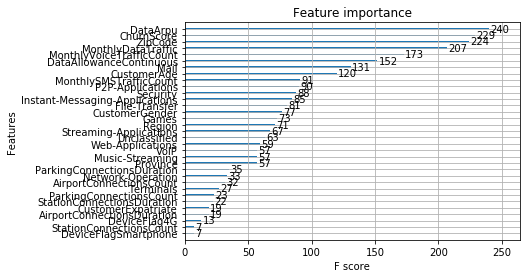

Feature_Importances: 
Index(['DeviceFlag4G', 'ZipCode', 'CustomerExpatriate',
       'MonthlySMSTrafficCount', 'DeviceFlagSmartphone', 'DataArpu',
       'Instant-Messaging-Applications', 'Web-Applications',
       'MonthlyVoiceTrafficCount', 'Network-Operation'],
      dtype='object')
Model: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'multi:softprob', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': 1, 'subsample': 1, 'num_class': 4}
n_estimator: 100


100

In [8]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb0 = XGBClassifier(
        objective='multi:softprob',
        num_class=4)
# print(train[predictors].values)
modelfit(xgb0, train, predictors)

In [9]:
learning_rate = 0.1
n_estimators = 1000
max_depth = 5
min_child_weight = 1
gamma = 0
subsample = 0.8
colsample_bytree = 0.8
reg_alpha = 0.005
cv = 5

[0]	train-merror:0.377548+0.00229726	test-merror:0.413817+0.0103026
[1]	train-merror:0.368141+0.00103387	test-merror:0.407859+0.00929939
[2]	train-merror:0.364377+0.00389966	test-merror:0.405768+0.00791067
[3]	train-merror:0.360144+0.00131836	test-merror:0.40002+0.00573827
[4]	train-merror:0.358419+0.00215498	test-merror:0.401379+0.00390386
[5]	train-merror:0.356433+0.00203045	test-merror:0.399916+0.00443046
[6]	train-merror:0.354683+0.00211395	test-merror:0.39887+0.00539516
[7]	train-merror:0.352827+0.0023388	test-merror:0.398138+0.00529579
[8]	train-merror:0.351338+0.00223813	test-merror:0.397198+0.00485902
[9]	train-merror:0.350083+0.0019854	test-merror:0.396675+0.00596361
[10]	train-merror:0.348725+0.00225553	test-merror:0.396883+0.00803925
[11]	train-merror:0.346922+0.00252438	test-merror:0.396152+0.0070527
[12]	train-merror:0.344596+0.00233536	test-merror:0.395421+0.00756463
[13]	train-merror:0.343368+0.00264325	test-merror:0.393853+0.00681277
[14]	train-merror:0.342558+0.0018813

[118]	train-merror:0.210959+0.00197594	test-merror:0.385804+0.00567062
[119]	train-merror:0.209601+0.00185776	test-merror:0.385595+0.00637171
[120]	train-merror:0.208451+0.00190211	test-merror:0.386013+0.00526997
[121]	train-merror:0.207484+0.00172673	test-merror:0.385909+0.00509325
[122]	train-merror:0.206543+0.00206532	test-merror:0.386327+0.00423633
[123]	train-merror:0.20623+0.00211086	test-merror:0.386222+0.00386146
[124]	train-merror:0.204923+0.00198282	test-merror:0.386118+0.00379968
[125]	train-merror:0.204061+0.00197299	test-merror:0.385804+0.00473118
[126]	train-merror:0.203381+0.00167158	test-merror:0.385491+0.00422218
[127]	train-merror:0.202388+0.00190302	test-merror:0.385177+0.00483807
[128]	train-merror:0.201683+0.00229632	test-merror:0.384132+0.00510967
[129]	train-merror:0.200533+0.00182532	test-merror:0.385387+0.005192
[130]	train-merror:0.199723+0.00144974	test-merror:0.385909+0.00447332
[131]	train-merror:0.198521+0.00179694	test-merror:0.385282+0.00429942
[132]	tra

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.7764
F1_score : 0.776419


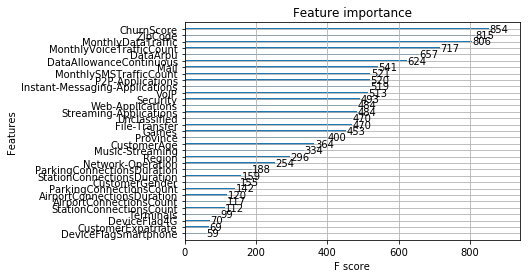

Feature_Importances: 
Index(['ZipCode', 'CustomerExpatriate', 'MonthlySMSTrafficCount',
       'DeviceFlagSmartphone', 'DeviceFlag4G', 'DataArpu',
       'Instant-Messaging-Applications', 'MonthlyVoiceTrafficCount',
       'Network-Operation', 'Games'],
      dtype='object')
Model: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 129, 'nthread': 4, 'objective': 'multi:softprob', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': 1, 'subsample': 0.8, 'num_class': 4}
n_estimator: 129


In [10]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='multi:softprob',
        num_class=4,
        nthread=4,
        scale_pos_weight=1,
        seed=27)
n_estimators = modelfit(xgb1, train, predictors)

In [11]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample,
                                        colsample_bytree=colsample_bytree, objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='f1_micro',n_jobs=4,iid=False, cv=cv,verbose=1)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.5min finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61252, std: 0.00391, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.61398, std: 0.00650, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.61367, std: 0.00385, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.61325, std: 0.00796, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.61346, std: 0.00826, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.61179, std: 0.00575, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.61158, std: 0.00727, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.60865, std: 0.00683, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.61012, std: 0.00688, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.61095, std: 0.00553, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.60876, std: 0.00850, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.60813, std: 0.00888, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 3

In [12]:
max_depth = gsearch1.best_params_['max_depth']
min_child_weight = gsearch1.best_params_['min_child_weight']
max_depth,min_child_weight

(3, 3)

In [13]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2 = {
    'max_depth':[max_depth-1,max_depth,max_depth+1],
    'min_child_weight':[min_child_weight-1,min_child_weight,min_child_weight+1]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='f1_micro',n_jobs=4,iid=False, cv=cv, verbose=1)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.2min finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.60803, std: 0.00498, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.60761, std: 0.00462, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.60771, std: 0.00499, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.61273, std: 0.00514, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.61398, std: 0.00650, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.61398, std: 0.00551, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.61294, std: 0.00580, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.61158, std: 0.00556, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.61430, std: 0.00542, params: {'max_depth': 4, 'min_child_weight': 4}],
 {'max_depth': 4, 'min_child_weight': 4},
 0.6142988678002869)

In [14]:
max_depth = gsearch2.best_params_['max_depth']
min_child_weight = gsearch2.best_params_['min_child_weight']
max_depth,min_child_weight

(4, 4)

In [15]:
#Grid seach on subsample and max_features#Grid se 
#Choose all predictors except target & IDcols
param_test2b = {
    'min_child_weight':[min_child_weight,min_child_weight+2,min_child_weight+4,min_child_weight+6]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2b, scoring='f1_micro',n_jobs=4,iid=False, cv=cv, verbose=1)
gsearch2b.fit(train[predictors],train[target])
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   33.8s finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61430, std: 0.00542, params: {'min_child_weight': 4},
  mean: 0.61252, std: 0.00507, params: {'min_child_weight': 6},
  mean: 0.61325, std: 0.00410, params: {'min_child_weight': 8},
  mean: 0.61378, std: 0.00528, params: {'min_child_weight': 10}],
 {'min_child_weight': 4},
 0.6142988678002869)

In [16]:
min_child_weight = gsearch2b.best_params_['min_child_weight']
min_child_weight

4

In [17]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3, scoring='f1_micro',n_jobs=4,iid=False, cv=cv, verbose=1)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   38.9s finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61430, std: 0.00542, params: {'gamma': 0.0},
  mean: 0.61472, std: 0.00492, params: {'gamma': 0.1},
  mean: 0.61534, std: 0.00654, params: {'gamma': 0.2},
  mean: 0.61566, std: 0.00719, params: {'gamma': 0.3},
  mean: 0.61336, std: 0.00736, params: {'gamma': 0.4}],
 {'gamma': 0.3},
 0.6156562410438927)

In [18]:
gamma = gsearch3.best_params_['gamma']
gamma

0.3

[0]	train-merror:0.393305+0.00141842	test-merror:0.414236+0.00432257
[1]	train-merror:0.386067+0.00283944	test-merror:0.411517+0.00935171
[2]	train-merror:0.385727+0.00216508	test-merror:0.406082+0.00567963
[3]	train-merror:0.381206+0.00259685	test-merror:0.40326+0.00360411
[4]	train-merror:0.380553+0.0026223	test-merror:0.404096+0.00428388
[5]	train-merror:0.378881+0.00180764	test-merror:0.40326+0.00439883
[6]	train-merror:0.377469+0.00142498	test-merror:0.40002+0.00560687
[7]	train-merror:0.376058+0.00235098	test-merror:0.399079+0.00553952
[8]	train-merror:0.373732+0.00211467	test-merror:0.40002+0.00504026
[9]	train-merror:0.373471+0.00233052	test-merror:0.398661+0.00481812
[10]	train-merror:0.372426+0.00299716	test-merror:0.398034+0.00471565
[11]	train-merror:0.372191+0.00285669	test-merror:0.395839+0.00533953
[12]	train-merror:0.37125+0.00239646	test-merror:0.395735+0.00461592
[13]	train-merror:0.370623+0.00238107	test-merror:0.396362+0.00447878
[14]	train-merror:0.369212+0.0025125

[118]	train-merror:0.281331+0.00276988	test-merror:0.385386+0.00707337
[119]	train-merror:0.280731+0.00261468	test-merror:0.3857+0.00674315
[120]	train-merror:0.279633+0.00248153	test-merror:0.385386+0.0067416
[121]	train-merror:0.278823+0.00238838	test-merror:0.386222+0.00592101
[122]	train-merror:0.27817+0.00254866	test-merror:0.386536+0.0075166
[123]	train-merror:0.27736+0.00294361	test-merror:0.386118+0.00728816
[124]	train-merror:0.276445+0.00291929	test-merror:0.38664+0.00693466
[125]	train-merror:0.275922+0.00288072	test-merror:0.386536+0.00665714
[126]	train-merror:0.275112+0.00289146	test-merror:0.386326+0.00699221
[127]	train-merror:0.274171+0.00319149	test-merror:0.386745+0.00689647
[128]	train-merror:0.274015+0.00360538	test-merror:0.38664+0.00693466
[129]	train-merror:0.273492+0.00316148	test-merror:0.38664+0.00741631
[130]	train-merror:0.272917+0.00331266	test-merror:0.386744+0.00783552
[131]	train-merror:0.272447+0.00342192	test-merror:0.386117+0.00796006
[132]	train-mer

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.6897
F1_score : 0.689662


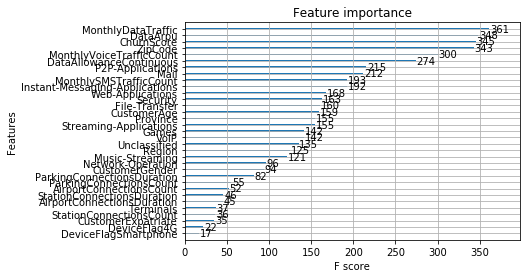

Feature_Importances: 
Index(['MonthlySMSTrafficCount', 'DeviceFlag4G', 'ZipCode',
       'CustomerExpatriate', 'DeviceFlagSmartphone', 'DataArpu',
       'Network-Operation', 'Instant-Messaging-Applications',
       'MonthlyVoiceTrafficCount', 'Games'],
      dtype='object')
Model: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 4, 'missing': None, 'n_estimators': 97, 'nthread': 4, 'objective': 'multi:softprob', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': 1, 'subsample': 0.8, 'num_class': 4}
n_estimator: 97


In [19]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(
        learning_rate =learning_rate,
        n_estimators=1000,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='multi:softprob', 
        num_class=4,
        nthread=4,
        scale_pos_weight=1,
        seed=27)
n_estimators = modelfit(xgb2, train, predictors)

# Tune subsample and colsample_bytree

In [20]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test4, scoring='f1_micro',n_jobs=4,iid=False, cv=cv, verbose=1)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   43.8s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  1.5min finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61284, std: 0.00268, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.61325, std: 0.00383, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.61336, std: 0.00811, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.61576, std: 0.00400, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.61304, std: 0.00300, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.61294, std: 0.00380, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.61315, std: 0.00406, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.61242, std: 0.00359, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.61534, std: 0.00180, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.61294, std: 0.00524, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.61618, std: 0.00372, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.61524, std: 0.00449, params: {'colsample_bytree': 0.8, 'subsample'

In [21]:
subsample = gsearch4.best_params_['subsample']
colsample_bytree = gsearch4.best_params_['colsample_bytree']
subsample,colsample_bytree

(0.8, 0.8)

In [22]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/100.0 for i in range(int(subsample*100-5),int(subsample*100+5),5)],
    'colsample_bytree':[i/100.0 for i in range(int(colsample_bytree*100-5),int(colsample_bytree*100+5),5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test5, scoring='f1_micro',n_jobs=4,iid=False, cv=cv, verbose=1)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   26.6s finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61263, std: 0.00431, params: {'colsample_bytree': 0.75, 'subsample': 0.75},
  mean: 0.61461, std: 0.00216, params: {'colsample_bytree': 0.75, 'subsample': 0.8},
  mean: 0.61482, std: 0.00335, params: {'colsample_bytree': 0.8, 'subsample': 0.75},
  mean: 0.61618, std: 0.00372, params: {'colsample_bytree': 0.8, 'subsample': 0.8}],
 {'colsample_bytree': 0.8, 'subsample': 0.8},
 0.6161797452004133)

In [23]:
subsample = gsearch5.best_params_['subsample']
colsample_bytree = gsearch5.best_params_['colsample_bytree']
subsample,colsample_bytree

(0.8, 0.8)

# regularization:

In [24]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test6, scoring='f1_micro',n_jobs=4,iid=False, cv=cv, verbose=1)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   31.9s finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61618, std: 0.00372, params: {'reg_alpha': 1e-05},
  mean: 0.61681, std: 0.00401, params: {'reg_alpha': 0.01},
  mean: 0.61367, std: 0.00417, params: {'reg_alpha': 0.1},
  mean: 0.61482, std: 0.00466, params: {'reg_alpha': 1},
  mean: 0.58880, std: 0.00337, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.01},
 0.6168065949169966)

In [25]:
reg_alpha = gsearch6.best_params_['reg_alpha']
reg_alpha

0.01

In [26]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test7, scoring='f1_micro',n_jobs=4,iid=False, cv=cv,verbose=1)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   33.7s finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61618, std: 0.00372, params: {'reg_alpha': 0},
  mean: 0.61597, std: 0.00292, params: {'reg_alpha': 0.001},
  mean: 0.61639, std: 0.00389, params: {'reg_alpha': 0.005},
  mean: 0.61681, std: 0.00401, params: {'reg_alpha': 0.01},
  mean: 0.61461, std: 0.00417, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.01},
 0.6168065949169966)

In [27]:
reg_alpha = gsearch7.best_params_['reg_alpha']
reg_alpha

0.01

[0]	train-merror:0.393305+0.00141842	test-merror:0.414236+0.00432257
[1]	train-merror:0.386015+0.00274088	test-merror:0.410995+0.0093413
[2]	train-merror:0.385936+0.00235752	test-merror:0.406082+0.00567963
[3]	train-merror:0.381337+0.00270844	test-merror:0.403051+0.00343787
[4]	train-merror:0.380239+0.00223997	test-merror:0.404096+0.00412035
[5]	train-merror:0.378828+0.00175527	test-merror:0.402842+0.00406006
[6]	train-merror:0.377286+0.00127592	test-merror:0.40002+0.00560687
[7]	train-merror:0.376241+0.00242572	test-merror:0.399497+0.00541038
[8]	train-merror:0.373915+0.00226597	test-merror:0.400438+0.00495115
[9]	train-merror:0.37355+0.00240889	test-merror:0.399079+0.00484354
[10]	train-merror:0.37253+0.00296308	test-merror:0.398348+0.00476278
[11]	train-merror:0.372243+0.00289317	test-merror:0.396571+0.0051284
[12]	train-merror:0.37159+0.00237705	test-merror:0.39563+0.0046916
[13]	train-merror:0.370571+0.00230414	test-merror:0.396675+0.00439374
[14]	train-merror:0.369447+0.00255423	

[118]	train-merror:0.281149+0.0027928	test-merror:0.382564+0.00661305
[119]	train-merror:0.280234+0.00272615	test-merror:0.382983+0.00645261
[120]	train-merror:0.279372+0.00264409	test-merror:0.382983+0.00619868
[121]	train-merror:0.278614+0.00272293	test-merror:0.382669+0.00622982
[122]	train-merror:0.278117+0.00259453	test-merror:0.382982+0.00629689
[123]	train-merror:0.277961+0.0029192	test-merror:0.383087+0.00575454
[124]	train-merror:0.277229+0.002598	test-merror:0.382878+0.0052449
[125]	train-merror:0.276158+0.00238602	test-merror:0.383505+0.00536172
[126]	train-merror:0.275766+0.00273206	test-merror:0.383715+0.00484719
[127]	train-merror:0.274955+0.00275996	test-merror:0.384028+0.00548868
[128]	train-merror:0.274041+0.00252753	test-merror:0.384551+0.00492198
[129]	train-merror:0.273126+0.00253929	test-merror:0.385073+0.00514075
[130]	train-merror:0.272656+0.00265993	test-merror:0.384655+0.00538171
[131]	train-merror:0.272107+0.00225487	test-merror:0.384759+0.00588372
[132]	train

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.6914
F1_score : 0.691439


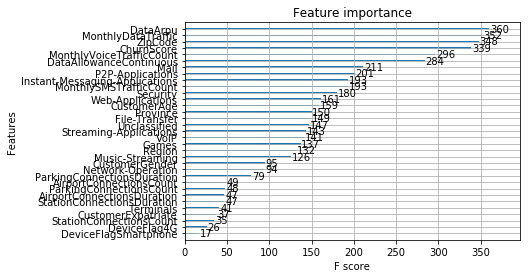

Feature_Importances: 
Index(['DeviceFlag4G', 'MonthlySMSTrafficCount', 'CustomerExpatriate',
       'ZipCode', 'DeviceFlagSmartphone', 'DataArpu',
       'Instant-Messaging-Applications', 'Network-Operation',
       'MonthlyVoiceTrafficCount', 'Games'],
      dtype='object')
Model: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 4, 'missing': None, 'n_estimators': 97, 'nthread': 4, 'objective': 'multi:softprob', 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': 1, 'subsample': 0.8, 'num_class': 4}
n_estimator: 97


In [28]:
xgb3 = XGBClassifier(
        learning_rate =learning_rate,
        n_estimators=1000,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        objective='multi:softprob', 
        num_class=4,
        nthread=4,
        scale_pos_weight=1,
        seed=27)
n_estimators = modelfit(xgb3, train, predictors)

[0]	train-merror:0.393305+0.00141842	test-merror:0.414236+0.00432257
[1]	train-merror:0.386015+0.00274088	test-merror:0.410995+0.0093413
[2]	train-merror:0.385936+0.00235752	test-merror:0.406082+0.00567963
[3]	train-merror:0.381337+0.00270844	test-merror:0.403051+0.00343787
[4]	train-merror:0.380239+0.00223997	test-merror:0.404096+0.00412035
[5]	train-merror:0.378828+0.00175527	test-merror:0.402842+0.00406006
[6]	train-merror:0.377286+0.00127592	test-merror:0.40002+0.00560687
[7]	train-merror:0.376241+0.00242572	test-merror:0.399497+0.00541038
[8]	train-merror:0.373915+0.00226597	test-merror:0.400438+0.00495115
[9]	train-merror:0.37355+0.00240889	test-merror:0.399079+0.00484354
[10]	train-merror:0.37253+0.00296308	test-merror:0.398348+0.00476278
[11]	train-merror:0.372243+0.00289317	test-merror:0.396571+0.0051284
[12]	train-merror:0.37159+0.00237705	test-merror:0.39563+0.0046916
[13]	train-merror:0.370571+0.00230414	test-merror:0.396675+0.00439374
[14]	train-merror:0.369447+0.00255423	

[118]	train-merror:0.281149+0.0027928	test-merror:0.382564+0.00661305
[119]	train-merror:0.280234+0.00272615	test-merror:0.382983+0.00645261
[120]	train-merror:0.279372+0.00264409	test-merror:0.382983+0.00619868
[121]	train-merror:0.278614+0.00272293	test-merror:0.382669+0.00622982
[122]	train-merror:0.278117+0.00259453	test-merror:0.382982+0.00629689
[123]	train-merror:0.277961+0.0029192	test-merror:0.383087+0.00575454
[124]	train-merror:0.277229+0.002598	test-merror:0.382878+0.0052449
[125]	train-merror:0.276158+0.00238602	test-merror:0.383505+0.00536172
[126]	train-merror:0.275766+0.00273206	test-merror:0.383715+0.00484719
[127]	train-merror:0.274955+0.00275996	test-merror:0.384028+0.00548868
[128]	train-merror:0.274041+0.00252753	test-merror:0.384551+0.00492198
[129]	train-merror:0.273126+0.00253929	test-merror:0.385073+0.00514075
[130]	train-merror:0.272656+0.00265993	test-merror:0.384655+0.00538171
[131]	train-merror:0.272107+0.00225487	test-merror:0.384759+0.00588372
[132]	train

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.6914
F1_score : 0.691439


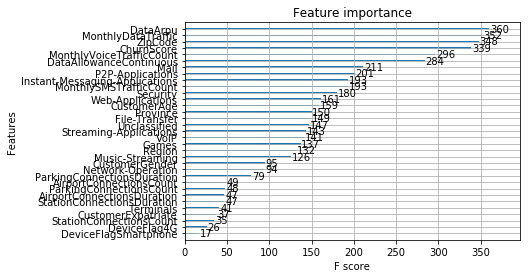

Feature_Importances: 
Index(['DeviceFlag4G', 'MonthlySMSTrafficCount', 'CustomerExpatriate',
       'ZipCode', 'DeviceFlagSmartphone', 'DataArpu',
       'Instant-Messaging-Applications', 'Network-Operation',
       'MonthlyVoiceTrafficCount', 'Games'],
      dtype='object')
Model: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 4, 'missing': None, 'n_estimators': 97, 'nthread': 4, 'objective': 'multi:softprob', 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': 1, 'subsample': 0.8, 'num_class': 4}
n_estimator: 97


In [29]:
xgb4 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=209,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        objective='multi:softprob', 
        num_class=4,
        nthread=4,
        scale_pos_weight=1,
        seed=27)
n_estimators = modelfit(xgb4, train, predictors)

In [30]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test8 = {
    #learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators' : [50, 100, 150, 200, 300]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test8, scoring='f1_micro',n_jobs=4,iid=False, cv=cv,verbose=1)
gsearch8.fit(train[predictors],train[target])
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  5.5min finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.59967, std: 0.00395, params: {'learning_rate': 0.0001, 'n_estimators': 50},
  mean: 0.60050, std: 0.00351, params: {'learning_rate': 0.0001, 'n_estimators': 100},
  mean: 0.60092, std: 0.00434, params: {'learning_rate': 0.0001, 'n_estimators': 150},
  mean: 0.60092, std: 0.00424, params: {'learning_rate': 0.0001, 'n_estimators': 200},
  mean: 0.60071, std: 0.00394, params: {'learning_rate': 0.0001, 'n_estimators': 300},
  mean: 0.60019, std: 0.00460, params: {'learning_rate': 0.001, 'n_estimators': 50},
  mean: 0.59967, std: 0.00422, params: {'learning_rate': 0.001, 'n_estimators': 100},
  mean: 0.60050, std: 0.00405, params: {'learning_rate': 0.001, 'n_estimators': 150},
  mean: 0.60071, std: 0.00374, params: {'learning_rate': 0.001, 'n_estimators': 200},
  mean: 0.60061, std: 0.00330, params: {'learning_rate': 0.001, 'n_estimators': 300},
  mean: 0.60134, std: 0.00401, params: {'learning_rate': 0.01, 'n_estimators': 50},
  mean: 0.60280, std: 0.00377, params: {'learning_rat

In [31]:
train.columns

Index(['ID', 'DeviceFlag4G', 'DataArpu', 'DataAllowanceContinuous',
       'DeviceFlagSmartphone', 'MonthlyVoiceTrafficCount',
       'MonthlySMSTrafficCount', 'MonthlyDataTraffic', 'CustomerGender',
       'CustomerExpatriate', 'ZipCode', 'ChurnScore',
       'AirportConnectionsDuration', 'AirportConnectionsCount',
       'StationConnectionsDuration', 'StationConnectionsCount',
       'ParkingConnectionsDuration', 'ParkingConnectionsCount',
       'File-Transfer', 'Games', 'Instant-Messaging-Applications', 'Mail',
       'Music-Streaming', 'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications', 'CustomerAge', 'Region', 'Province', 'Product'],
      dtype='object')

In [32]:
train[predictors].shape,train[target].shape,test[predictors].shape

((9567, 33), (9567,), (3190, 33))

In [33]:
pred = ['ZipCode', 'CustomerExpatriate', 'MonthlySMSTrafficCount',
       'DeviceFlagSmartphone', 'DeviceFlag4G', 'DataArpu', 'Region',
       'MonthlyVoiceTrafficCount', 'Instant-Messaging-Applications',
       'Unclassified']
train[pred].head()

,ZipCode,CustomerExpatriate,MonthlySMSTrafficCount,DeviceFlagSmartphone,DeviceFlag4G,DataArpu,Region,MonthlyVoiceTrafficCount,Instant-Messaging-Applications,Unclassified
0,39015.0,0.0,0.001623,1.0,1.0,0.156221,16.0,0.018229,0.000000,0.000000
1,0.0,0.0,0.001498,1.0,0.0,0.155086,0.0,0.051432,0.018201,0.001896
2,0.0,1.0,0.001248,1.0,1.0,0.000000,0.0,0.058594,0.336849,0.012055
3,25047.0,0.0,0.000499,1.0,1.0,0.155086,8.0,0.097005,0.585989,0.051692
4,30036.0,0.0,0.000375,1.0,1.0,0.155086,19.0,0.034505,0.032808,0.000857


[0]	train-merror:0.393305+0.00141842	test-merror:0.414236+0.00432257
[1]	train-merror:0.386015+0.00274088	test-merror:0.410995+0.0093413
[2]	train-merror:0.385936+0.00235752	test-merror:0.406082+0.00567963
[3]	train-merror:0.381337+0.00270844	test-merror:0.403051+0.00343787
[4]	train-merror:0.380239+0.00223997	test-merror:0.404096+0.00412035
[5]	train-merror:0.378828+0.00175527	test-merror:0.402842+0.00406006
[6]	train-merror:0.377286+0.00127592	test-merror:0.40002+0.00560687
[7]	train-merror:0.376241+0.00242572	test-merror:0.399497+0.00541038
[8]	train-merror:0.373915+0.00226597	test-merror:0.400438+0.00495115
[9]	train-merror:0.37355+0.00240889	test-merror:0.399079+0.00484354
[10]	train-merror:0.37253+0.00296308	test-merror:0.398348+0.00476278
[11]	train-merror:0.372243+0.00289317	test-merror:0.396571+0.0051284
[12]	train-merror:0.37159+0.00237705	test-merror:0.39563+0.0046916
[13]	train-merror:0.370571+0.00230414	test-merror:0.396675+0.00439374
[14]	train-merror:0.369447+0.00255423	

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.6914
F1_score : 0.691439


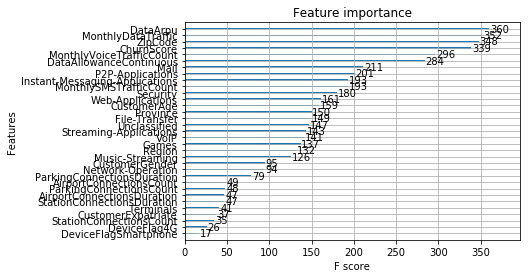

Feature_Importances: 
Index(['DeviceFlag4G', 'MonthlySMSTrafficCount', 'CustomerExpatriate',
       'ZipCode', 'DeviceFlagSmartphone', 'DataArpu',
       'Instant-Messaging-Applications', 'Network-Operation',
       'MonthlyVoiceTrafficCount', 'Games'],
      dtype='object')
Model: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 4, 'missing': None, 'n_estimators': 97, 'nthread': 4, 'objective': 'multi:softprob', 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': 1, 'subsample': 0.8, 'num_class': 4}
n_estimator: 97


In [34]:
xgb4 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        objective='multi:softprob', 
        num_class=4,
        nthread=4,
        scale_pos_weight=1,
        seed=27)
n_estimators = modelfit(xgb4, train, predictors)

In [35]:
# X_train, X_test, y_train, y_test = train_test_split(train[predictors], train[target], test_size=0.33, random_state=7)
# eval_set = [(X_test, y_test)]
xgb4.fit(train[pred],
      train[target],
      eval_metric="merror",
      verbose=True)

y_pred_new_data = xgb4.predict(test[pred])
predictions = [round(value) for value in y_pred_new_data]

print("F1 score on unseen data: %.3f%%" % (f1_score(train[target][0:3190], y_pred_new_data, average='micro')*100))

F1 score on unseen data: 47.053%


C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [36]:
pd.DataFrame({'Product': y_pred_new_data}).describe(),pd.DataFrame({'Product': predictions}).describe()

(           Product
 count  3190.000000
 mean      0.428840
 std       0.953833
 min       0.000000
 25%       0.000000
 50%       0.000000
 75%       0.000000
 max       3.000000,            Product
 count  3190.000000
 mean      0.428840
 std       0.953833
 min       0.000000
 25%       0.000000
 50%       0.000000
 75%       0.000000
 max       3.000000)

In [37]:
y = pd.DataFrame({'Product': y_pred_new_data})
submit = test['ID']
submit = pd.DataFrame({'ID': submit})

pred = y
pred = pd.DataFrame({'Product': y_pred_new_data})

product = []
product = pred.Product
product.replace({ 
    int(0) : 'Non-Customer', 
    int(1) : 'V-Bag', 
    int(2) : 'V-Pet', 
    int(3) : 'V-Auto'},
    inplace=True)

submit = submit.join(product)
submit

,ID,Product
0,271,Non-Customer
1,6929,Non-Customer
2,7381,Non-Customer
3,4408,V-Pet
4,5440,Non-Customer
5,4190,V-Auto
6,6524,Non-Customer
7,8562,Non-Customer
8,266,Non-Customer
9,12098,Non-Customer


In [38]:
submit.Product.describe()

count             3190
unique               4
top       Non-Customer
freq              2624
Name: Product, dtype: object

In [39]:
submit.to_csv('resultxgb.csv', index = False, encoding='utf-8')

In [40]:
# predictors = [x for x in train.columns if x not in [target]]
# # split data into X and y
# X = train[predictors]
# Y = train[target]
# # split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)
# # fit model on all training data
# model = XGBClassifier(
#         objective='multi:softprob', 
#         num_class=4)
# model.fit(X_train, y_train)
# # make predictions for test data and evaluate
# y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
# # Fit model using each importance as a threshold
# thresholds = sort(model.feature_importances_)
# for thresh in thresholds:
#     # select features using threshold
#     selection = SelectFromModel(model, threshold=thresh, prefit=True)
#     select_X_train = selection.transform(X_train)
#     # train model
#     selection_model = XGBClassifier(objective='multi:softprob', 
#         num_class=4)
#     selection_model.fit(select_X_train, y_train)
#     # eval model
#     select_X_test = selection.transform(X_test)
#     y_pred = selection_model.predict(select_X_test)
#     predictions = [round(value) for value in y_pred]
#     accuracy = accuracy_score(y_test, predictions)
#     print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

In [41]:
# thresholds = model.feature_importances_
# thresholds

# thresholds.argsort()[-10:][::-1]
# train.columns[thresholds.argsort()[-10:][::-1]]